In [1]:
# !pip install fastaudio
# !pip install fastai==2.5.2
# !pip install matplotlib==3.2.2
# !pip install scikit-learn==1.0.2

In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import*
from imblearn.metrics import specificity_score
from keras.utils.np_utils import to_categorical   

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


# Data preprocessing 

## Load data

In [3]:
# select data path
path = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/'

In [4]:
# load the given csv file
org_df = pd.read_csv(path+"patient_diagnosis.csv", names=['pid', 'label'])
org_df.head()

pid    label
0  101     URTI
1  102  Healthy
2  103   Asthma
3  104     COPD
4  105     URTI

In [5]:
# load all audio file paths in a list
all_files = get_files(path, extensions='.wav', recurse=True)
all_files[:3]

(#3) [Path('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/162_1b2_Ar_mc_AKGC417L.wav'),Path('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/193_1b2_Pl_mc_AKGC417L.wav'),Path('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/138_2p2_Ll_mc_AKGC417L.wav')]

## Create dataframe for dataloader

In [6]:
# save all audios filename and it's corresponding labels in lists
file_names = []
labels = []
for i in all_files:
    name = str(i).split('/')[-1]
    file_names.append(name)
    id = name.split('_')[0]
    label = org_df[org_df['pid']==int(id)]['label'].values[0]
    if (label == 'COPD' or label == 'Bronchiectasis' or label == 'Asthma'):
        labels.append('Chronic Disease')
    elif (label == 'URTI' or label == 'LRTI' or label =='Pneumonia' or label =='Bronchiolitis'):
        labels.append('Non-Chronic Disease')
    else:
        labels.append(label)
        
print("total files:", len(file_names))
print("total labels:", len(labels))

print(file_names[:3])
print(labels[:3])

Counter(labels)

total files: 920
total labels: 920
['162_1b2_Ar_mc_AKGC417L.wav', '193_1b2_Pl_mc_AKGC417L.wav', '138_2p2_Ll_mc_AKGC417L.wav']
['Chronic Disease', 'Chronic Disease', 'Chronic Disease']


Counter({'Chronic Disease': 810, 'Non-Chronic Disease': 75, 'Healthy': 35})

In [7]:
# create a dataframe using the file_names and labels list
df = pd.DataFrame({'filename' : file_names, 'category': labels})
six_df = df.copy()
six_df

filename         category
0    162_1b2_Ar_mc_AKGC417L.wav  Chronic Disease
1    193_1b2_Pl_mc_AKGC417L.wav  Chronic Disease
2    138_2p2_Ll_mc_AKGC417L.wav  Chronic Disease
3    207_2b2_Ar_mc_AKGC417L.wav  Chronic Disease
4    176_2b3_Pr_mc_AKGC417L.wav  Chronic Disease
..                          ...              ...
915  162_2b4_Al_mc_AKGC417L.wav  Chronic Disease
916  186_2b3_Ar_mc_AKGC417L.wav  Chronic Disease
917  111_1b3_Tc_sc_Meditron.wav  Chronic Disease
918  151_2p3_Al_mc_AKGC417L.wav  Chronic Disease
919  170_1b4_Pl_mc_AKGC417L.wav  Chronic Disease

[920 rows x 2 columns]

Chronic Disease        810
Non-Chronic Disease     75
Healthy                 35
Name: category, dtype: int64

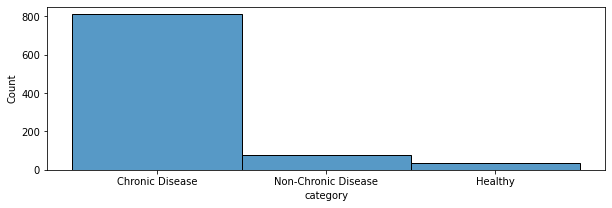

In [8]:
import seaborn as sns

plt.figure(figsize=(10,3))
sns.histplot(six_df['category'])

six_df['category'].value_counts()

In [9]:
six_df.to_csv('six_df.csv', index=False) 

## MFCC generate

In [10]:
# resize audio to a uniform length and create 40 mfccs

a2s = AudioToMFCC(sample_rate=22050, n_mfcc=70, log_mels=False, 
                       melkwargs={'n_fft':2048, 'hop_length':256,'n_mels':128})

crop21s = ResizeSignal(21000)

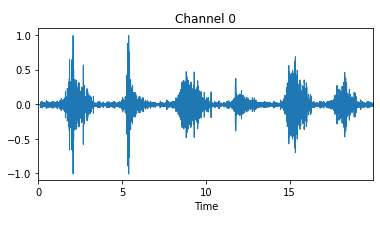

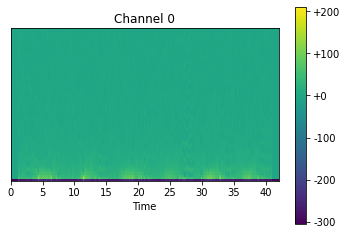

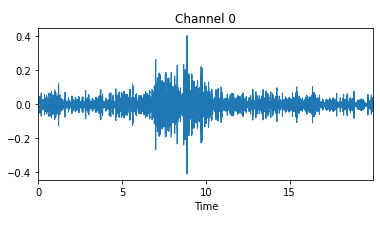

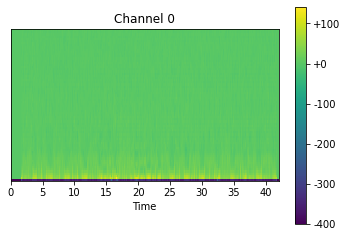

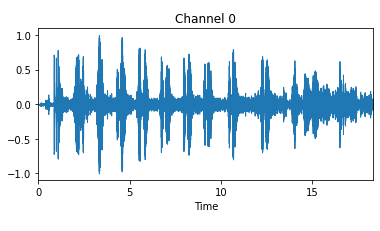

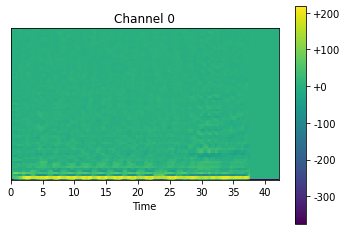

In [11]:
# check transformations
pipe = Pipeline([AudioTensor.create, crop21s, a2s])

for fn in all_files[23:26]:
      audio = AudioTensor.create(fn)
      audio.show()
      pipe(fn).show()

## Dataloader

In [12]:
six_df, six_df_test = train_test_split(six_df, test_size=0.20, random_state=42, 
                                       stratify=six_df.category.values)

print(six_df.category.value_counts())
print(six_df_test.category.value_counts())

Chronic Disease        648
Non-Chronic Disease     60
Healthy                 28
Name: category, dtype: int64
Chronic Disease        162
Non-Chronic Disease     15
Healthy                  7
Name: category, dtype: int64


Setting-up type transforms pipelines
59   170_1b4_Lr_mc_AKGC417L.wav  Chronic Disease
805  130_3p4_Tc_mc_AKGC417L.wav  Chronic Disease
376  158_1p3_Lr_mc_AKGC417L.wav  Chronic Disease
50   113_1b1_Ll_sc_Litt3200.wav  Chronic Disease
709  218_1b1_Pl_sc_Meditron.wav  Chronic Disease
..                          ...              ...
392  177_2b4_Pr_mc_AKGC417L.wav  Chronic Disease
21   170_1b4_Al_mc_AKGC417L.wav  Chronic Disease
128  186_2b4_Lr_mc_AKGC417L.wav  Chronic Disease
666  198_6p1_Ar_mc_AKGC417L.wav  Chronic Disease
164  141_1b3_Pr_mc_LittC2SE.wav  Chronic Disease

[736 rows x 2 columns]
Found 736 items
2 datasets of sizes 588,148
Setting up Pipeline: ColReader -- {'cols': 'filename', 'pref': '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/', 'suff': '', 'label_delim': None} -> partial
Setting up Pipeline: ColReader -- {'cols': 'category', 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab': None, 's

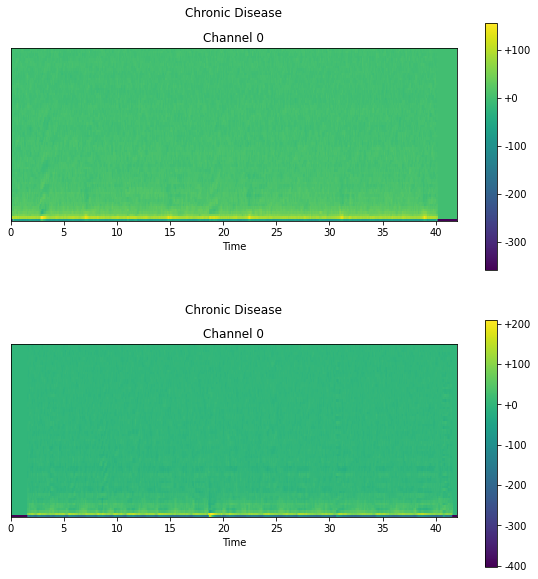

In [13]:
item_tfms = [crop21s, a2s]

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref= path+"audio_and_txt_files/"),
                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, 
                                              stratify=six_df.category.values),
                 item_tfms = item_tfms,
                 get_y = ColReader("category"))


auds.summary(six_df, show_batch=True, figsize=(10, 10))

## Check data distribution

In [14]:
dls = auds.dataloaders(six_df, bs=64)

for i in range(10):
    x,y = dls.one_batch()
    print(np.unique(y.cpu(), return_counts=True))

(array([0, 1, 2]), array([58,  4,  2]))
(array([0, 1, 2]), array([56,  1,  7]))
(array([0, 1, 2]), array([54,  4,  6]))
(array([0, 1, 2]), array([56,  1,  7]))
(array([0, 1, 2]), array([59,  3,  2]))
(array([0, 1, 2]), array([58,  2,  4]))
(array([0, 1, 2]), array([53,  1, 10]))
(array([0, 1, 2]), array([57,  3,  4]))
(array([0, 1, 2]), array([57,  3,  4]))
(array([0, 1, 2]), array([54,  2,  8]))


In [15]:
test_dl = dls.test_dl(six_df_test, with_labels=True)

In [16]:
print(dls.valid.items.category.value_counts())
print(dls.valid.items.category.value_counts())
print(test_dl.items.category.value_counts())

Chronic Disease        130
Non-Chronic Disease     12
Healthy                  6
Name: category, dtype: int64
Chronic Disease        130
Non-Chronic Disease     12
Healthy                  6
Name: category, dtype: int64
Chronic Disease        162
Non-Chronic Disease     15
Healthy                  7
Name: category, dtype: int64


# Models: Fine-tuning

### ResNet-18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.06081081181764603.


Better model found at epoch 0 with accuracy value: 0.3378378450870514.
Better model found at epoch 1 with accuracy value: 0.6891891956329346.
Better model found at epoch 2 with accuracy value: 0.75.
Better model found at epoch 3 with accuracy value: 0.7905405163764954.
Better model found at epoch 4 with accuracy value: 0.8513513803482056.
Better model found at epoch 6 with accuracy value: 0.8783783912658691.
Better model found at epoch 7 with accuracy value: 0.9324324131011963.
Better model found at epoch 13 with accuracy value: 0.9459459185600281.
No improvement since epoch 13: early stopping


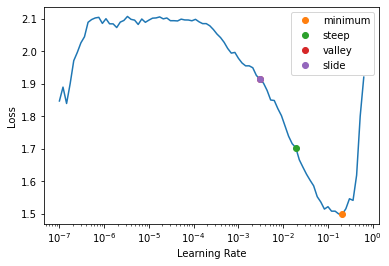

In [19]:
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

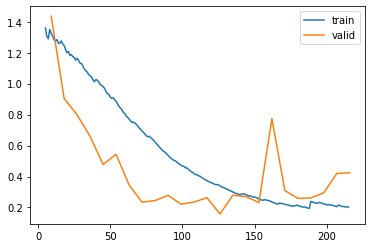

In [20]:
learn.recorder.plot_loss()

0.9347826086956522 0.8863124824590853 0.739781746031746 0.8087595532039976 0.9638654117141732 0.7240807715491261
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       162
           1       0.43      0.86      0.57         7
           2       0.75      0.60      0.67        15

    accuracy                           0.93       184
   macro avg       0.72      0.81      0.74       184
weighted avg       0.95      0.93      0.94       184



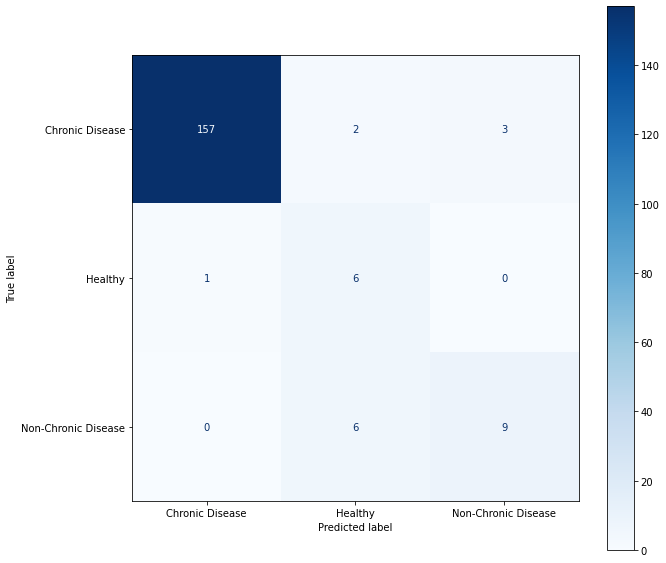

In [24]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-34

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.07432432472705841.


Better model found at epoch 0 with accuracy value: 0.23648647964000702.
Better model found at epoch 1 with accuracy value: 0.5675675868988037.
Better model found at epoch 2 with accuracy value: 0.6756756901741028.
Better model found at epoch 3 with accuracy value: 0.7567567825317383.
Better model found at epoch 4 with accuracy value: 0.7770270109176636.
Better model found at epoch 5 with accuracy value: 0.8040540814399719.
Better model found at epoch 6 with accuracy value: 0.8581081032752991.
Better model found at epoch 7 with accuracy value: 0.8648648858070374.
Better model found at epoch 8 with accuracy value: 0.9189189076423645.
Better model found at epoch 10 with accuracy value: 0.9391891956329346.
Better model found at epoch 19 with accuracy value: 0.9459459185600281.
Better model found at epoch 28 with accuracy value: 0.9527027010917664.
No improvement since epoch 28: early stopping


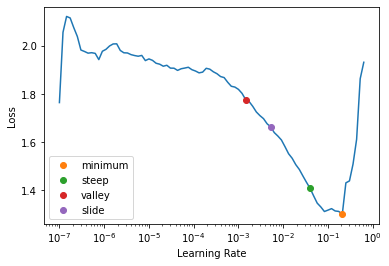

In [25]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

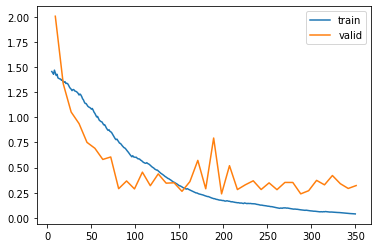

In [26]:
learn.recorder.plot_loss()

0.9239130434782609 0.7518355017268533 0.6001533742331289 0.5970017636684304 0.9066692397852764 0.6303602741909772
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       162
           1       0.33      0.14      0.20         7
           2       0.59      0.67      0.62        15

    accuracy                           0.92       184
   macro avg       0.63      0.60      0.60       184
weighted avg       0.91      0.92      0.92       184



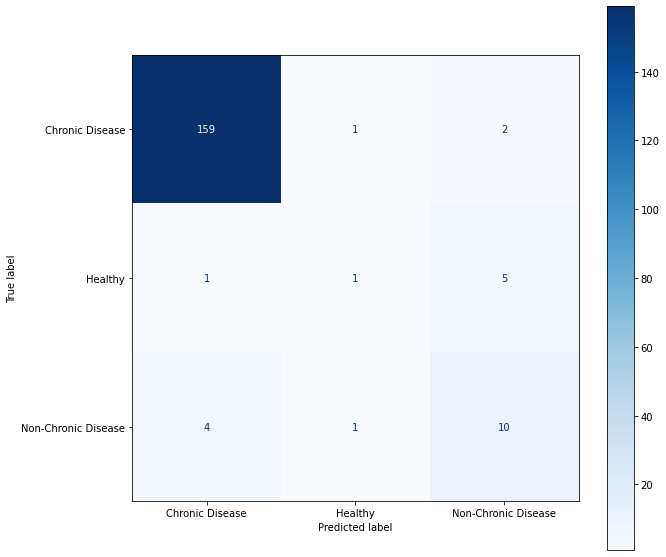

In [27]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.10810811072587967.


Better model found at epoch 0 with accuracy value: 0.2432432472705841.
Better model found at epoch 1 with accuracy value: 0.5337837934494019.
Better model found at epoch 2 with accuracy value: 0.6418918967247009.
Better model found at epoch 3 with accuracy value: 0.7702702879905701.
Better model found at epoch 4 with accuracy value: 0.837837815284729.
Better model found at epoch 6 with accuracy value: 0.8716216087341309.
Better model found at epoch 8 with accuracy value: 0.9189189076423645.
Better model found at epoch 9 with accuracy value: 0.9256756901741028.
Better model found at epoch 13 with accuracy value: 0.9324324131011963.
Better model found at epoch 14 with accuracy value: 0.9527027010917664.
No improvement since epoch 14: early stopping


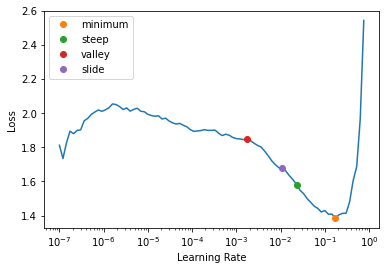

In [28]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

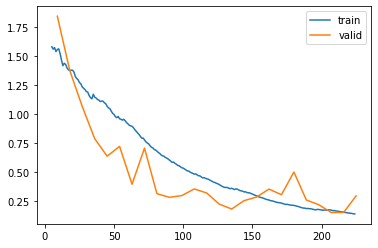

In [29]:
learn.recorder.plot_loss()

0.9239130434782609 0.7640086248517366 0.6888969595025104 0.6477954144620811 0.8802218352413919 0.7597532989099255
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       162
           1       0.75      0.43      0.55         7
           2       0.57      0.53      0.55        15

    accuracy                           0.92       184
   macro avg       0.76      0.65      0.69       184
weighted avg       0.92      0.92      0.92       184



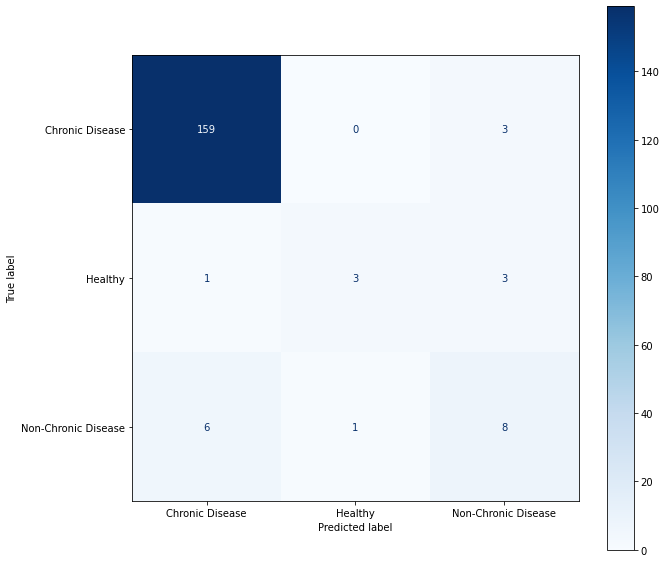

In [30]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-101

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.0810810774564743.


Better model found at epoch 0 with accuracy value: 0.18918919563293457.
Better model found at epoch 1 with accuracy value: 0.45270270109176636.
Better model found at epoch 2 with accuracy value: 0.587837815284729.
Better model found at epoch 4 with accuracy value: 0.6216216087341309.
Better model found at epoch 5 with accuracy value: 0.6554054021835327.
Better model found at epoch 6 with accuracy value: 0.7364864945411682.
Better model found at epoch 9 with accuracy value: 0.7567567825317383.
Better model found at epoch 10 with accuracy value: 0.7905405163764954.
Better model found at epoch 11 with accuracy value: 0.8040540814399719.
Better model found at epoch 12 with accuracy value: 0.8648648858070374.
Better model found at epoch 14 with accuracy value: 0.8851351141929626.
Better model found at epoch 16 with accuracy value: 0.8986486196517944.
Better model found at epoch 19 with accuracy value: 0.9189189076423645.
Better model found at epoch 21 with accuracy value: 0.9324324131011963

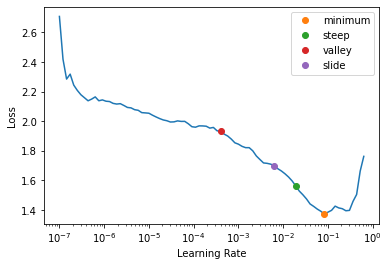

In [31]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

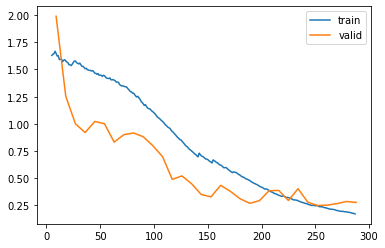

In [32]:
learn.recorder.plot_loss()

0.9130434782608695 0.8555609131373293 0.6822813141751465 0.7549676660787772 0.9561541601958812 0.6565796210957502
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       162
           1       0.33      0.71      0.45         7
           2       0.64      0.60      0.62        15

    accuracy                           0.91       184
   macro avg       0.66      0.75      0.68       184
weighted avg       0.94      0.91      0.92       184



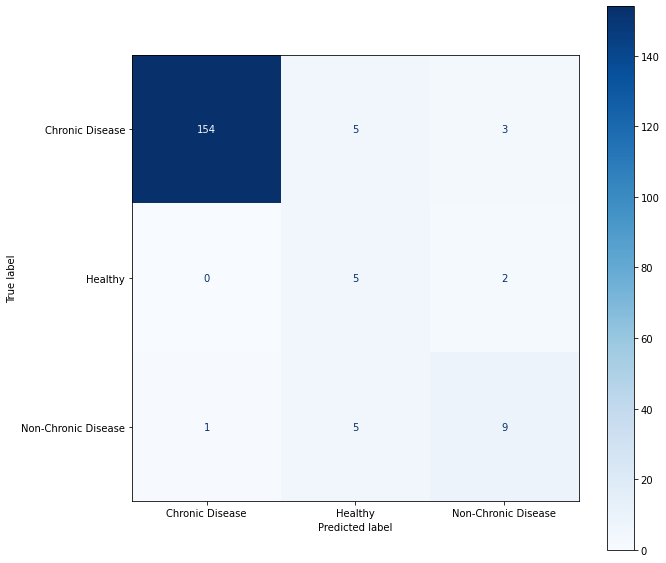

In [33]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg16_bn

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.46621620655059814.


Better model found at epoch 0 with accuracy value: 0.25.
Better model found at epoch 1 with accuracy value: 0.27702704071998596.
Better model found at epoch 2 with accuracy value: 0.3513513505458832.
Better model found at epoch 3 with accuracy value: 0.4054054021835327.
Better model found at epoch 4 with accuracy value: 0.5135135054588318.
Better model found at epoch 5 with accuracy value: 0.5675675868988037.
Better model found at epoch 6 with accuracy value: 0.6756756901741028.
Better model found at epoch 7 with accuracy value: 0.6891891956329346.
Better model found at epoch 8 with accuracy value: 0.7770270109176636.
Better model found at epoch 9 with accuracy value: 0.8445945978164673.
Better model found at epoch 10 with accuracy value: 0.8513513803482056.
Better model found at epoch 12 with accuracy value: 0.8581081032752991.
Better model found at epoch 14 with accuracy value: 0.8918918967247009.
Better model found at epoch 15 with accuracy value: 0.8986486196517944.
Better model fo

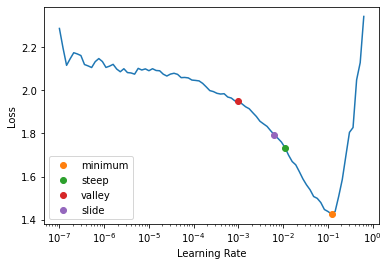

In [34]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

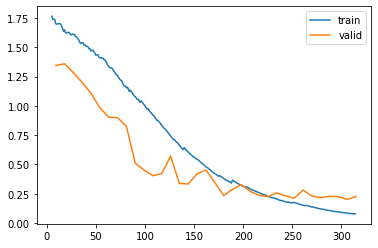

In [35]:
learn.recorder.plot_loss()

0.9293478260869565 0.8382107585569849 0.7066761927443043 0.740975896531452 0.9354456205825176 0.708435284522241
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       162
           1       0.42      0.71      0.53         7
           2       0.73      0.53      0.62        15

    accuracy                           0.93       184
   macro avg       0.71      0.74      0.71       184
weighted avg       0.94      0.93      0.93       184



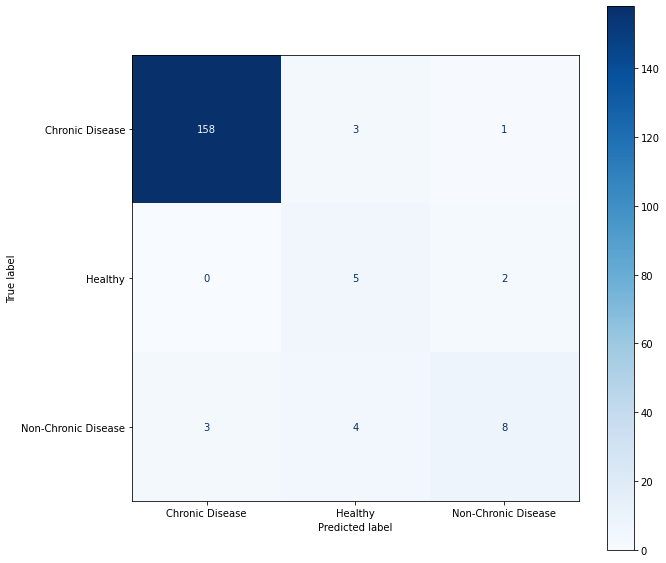

In [36]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg19_bn

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.20945945382118225.


Better model found at epoch 0 with accuracy value: 0.5810810923576355.
Better model found at epoch 1 with accuracy value: 0.7837837934494019.
Better model found at epoch 2 with accuracy value: 0.837837815284729.
Better model found at epoch 3 with accuracy value: 0.8445945978164673.
Better model found at epoch 4 with accuracy value: 0.8648648858070374.
Better model found at epoch 5 with accuracy value: 0.8918918967247009.
Better model found at epoch 7 with accuracy value: 0.9256756901741028.
Better model found at epoch 9 with accuracy value: 0.9594594836235046.
No improvement since epoch 9: early stopping


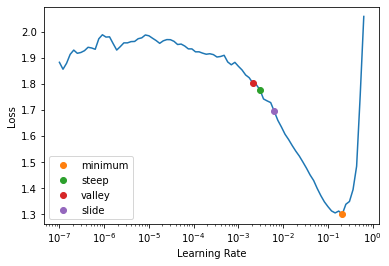

In [37]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

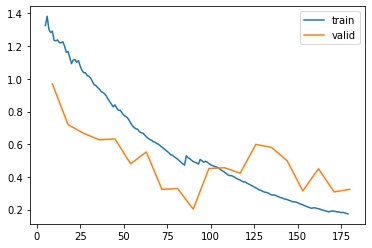

In [38]:
learn.recorder.plot_loss()

0.9293478260869565 0.73054449480641 0.6062231510507372 0.5788947677836567 0.8821942218291632 0.7003968253968255
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       162
           1       0.50      0.14      0.22         7
           2       0.64      0.60      0.62        15

    accuracy                           0.93       184
   macro avg       0.70      0.58      0.61       184
weighted avg       0.92      0.93      0.92       184



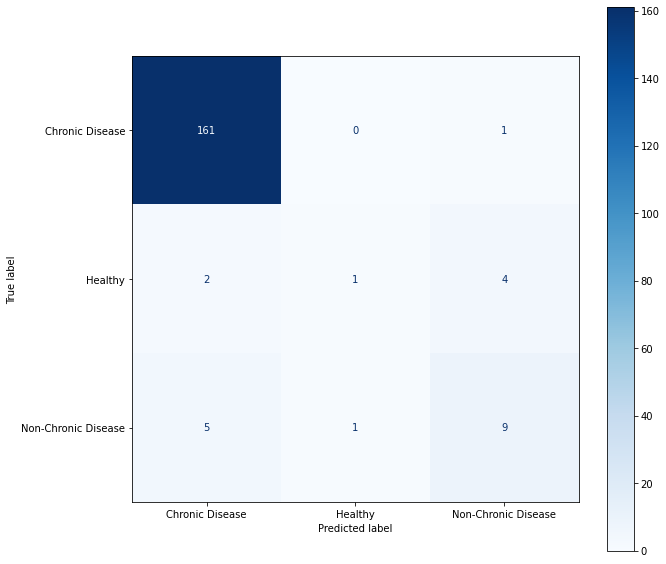

In [39]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.4797297418117523.


Better model found at epoch 0 with accuracy value: 0.6351351141929626.
Better model found at epoch 2 with accuracy value: 0.6689189076423645.
Better model found at epoch 3 with accuracy value: 0.7027027010917664.
Better model found at epoch 4 with accuracy value: 0.75.
Better model found at epoch 5 with accuracy value: 0.7972972989082336.
Better model found at epoch 9 with accuracy value: 0.8243243098258972.
Better model found at epoch 10 with accuracy value: 0.8716216087341309.
Better model found at epoch 11 with accuracy value: 0.8783783912658691.
Better model found at epoch 16 with accuracy value: 0.9324324131011963.
Better model found at epoch 17 with accuracy value: 0.9459459185600281.
No improvement since epoch 17: early stopping


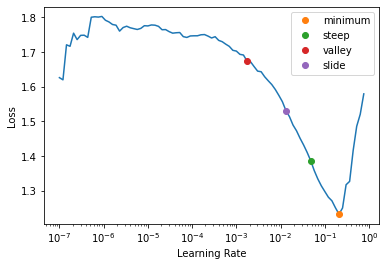

In [17]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

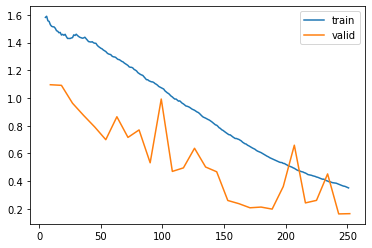

In [18]:
learn.recorder.plot_loss()

0.8967391304347826 0.7184544955369235 0.564432686654909 0.5665490887713109 0.8703599023025359 0.6355967078189301
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       162
           1       0.50      0.14      0.22         7
           2       0.45      0.60      0.51        15

    accuracy                           0.90       184
   macro avg       0.64      0.57      0.56       184
weighted avg       0.90      0.90      0.89       184



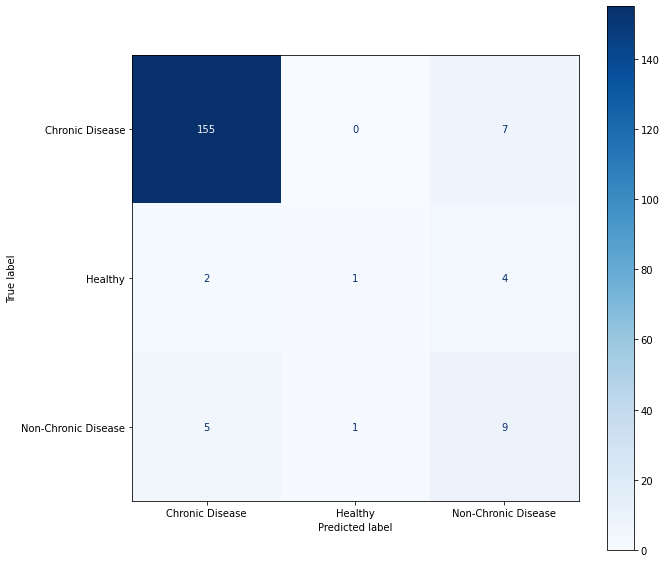

In [19]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### squeezenet1_0

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.30405405163764954.


Better model found at epoch 0 with accuracy value: 0.44594594836235046.
Better model found at epoch 1 with accuracy value: 0.4864864945411682.
Better model found at epoch 2 with accuracy value: 0.5743243098258972.
Better model found at epoch 3 with accuracy value: 0.7770270109176636.
Better model found at epoch 6 with accuracy value: 0.8581081032752991.
Better model found at epoch 7 with accuracy value: 0.8783783912658691.
Better model found at epoch 9 with accuracy value: 0.9054054021835327.
Better model found at epoch 11 with accuracy value: 0.9256756901741028.
Better model found at epoch 17 with accuracy value: 0.9324324131011963.
Better model found at epoch 18 with accuracy value: 0.9391891956329346.
Better model found at epoch 27 with accuracy value: 0.9527027010917664.
No improvement since epoch 27: early stopping


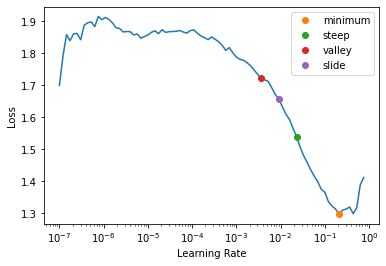

In [43]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

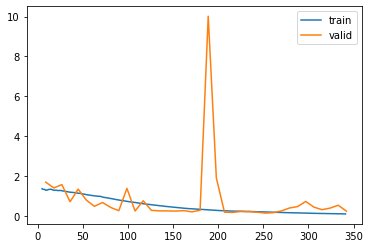

In [44]:
learn.recorder.plot_loss()

0.9130434782608695 0.790052491008597 0.6479813664596273 0.6638447971781304 0.9162601848390636 0.6361111111111111
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       162
           1       0.33      0.43      0.38         7
           2       0.60      0.60      0.60        15

    accuracy                           0.91       184
   macro avg       0.64      0.66      0.65       184
weighted avg       0.92      0.91      0.92       184



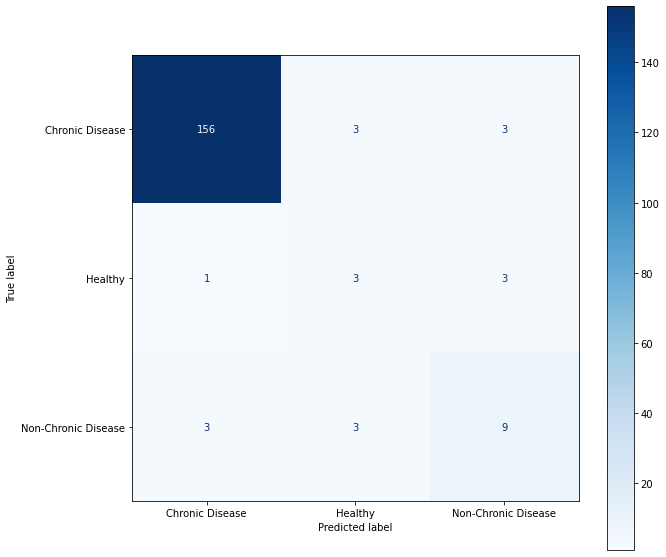

In [45]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### densenet121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.4256756901741028.


Better model found at epoch 0 with accuracy value: 0.3986486494541168.
Better model found at epoch 2 with accuracy value: 0.4932432472705841.
Better model found at epoch 3 with accuracy value: 0.6216216087341309.
Better model found at epoch 4 with accuracy value: 0.6418918967247009.
Better model found at epoch 5 with accuracy value: 0.6756756901741028.
Better model found at epoch 6 with accuracy value: 0.8108108043670654.
Better model found at epoch 7 with accuracy value: 0.8716216087341309.
Better model found at epoch 8 with accuracy value: 0.8986486196517944.
Better model found at epoch 9 with accuracy value: 0.912162184715271.
Better model found at epoch 12 with accuracy value: 0.9324324131011963.
Better model found at epoch 15 with accuracy value: 0.9594594836235046.
No improvement since epoch 15: early stopping


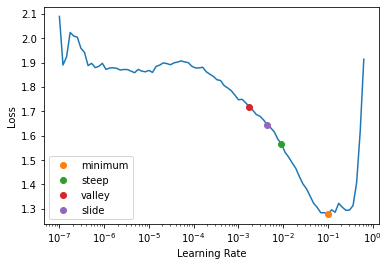

In [46]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

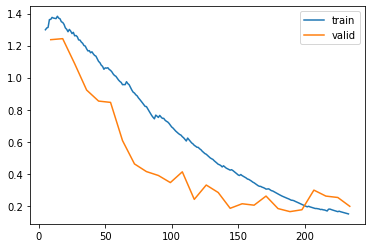

In [47]:
learn.recorder.plot_loss()

0.9293478260869565 0.8454986600792772 0.7366859516392226 0.7559082892416226 0.9350890309169319 0.7212239193371269
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       162
           1       0.57      0.57      0.57         7
           2       0.61      0.73      0.67        15

    accuracy                           0.93       184
   macro avg       0.72      0.76      0.74       184
weighted avg       0.94      0.93      0.93       184



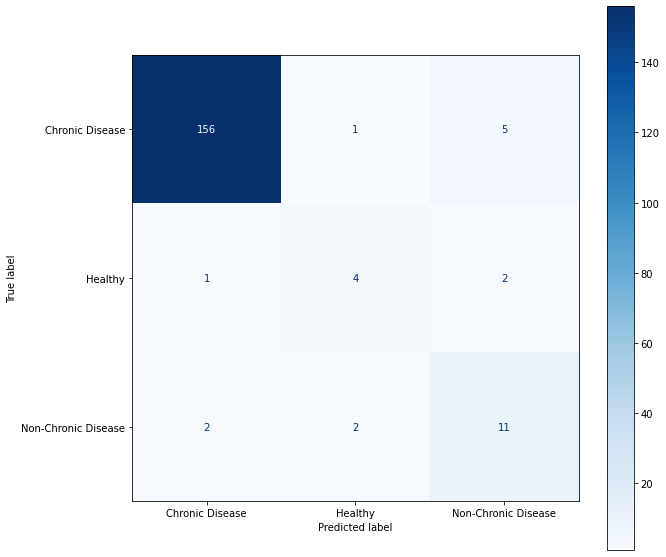

In [48]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### xresnet50

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.5540540814399719.


Better model found at epoch 0 with accuracy value: 0.6013513803482056.
Better model found at epoch 1 with accuracy value: 0.7635135054588318.
Better model found at epoch 3 with accuracy value: 0.8175675868988037.
Better model found at epoch 6 with accuracy value: 0.8716216087341309.
Better model found at epoch 9 with accuracy value: 0.8918918967247009.
Better model found at epoch 12 with accuracy value: 0.9189189076423645.
Better model found at epoch 15 with accuracy value: 0.9256756901741028.
Better model found at epoch 23 with accuracy value: 0.9391891956329346.
No improvement since epoch 23: early stopping


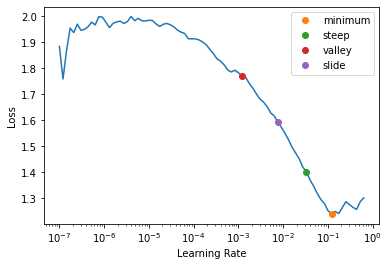

In [49]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

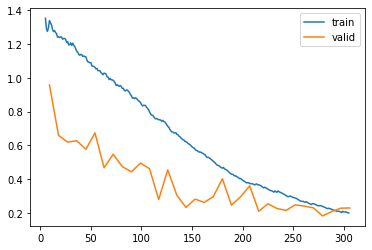

In [50]:
learn.recorder.plot_loss()

0.9239130434782609 0.8355813216888112 0.7311788913096103 0.7643151087595532 0.9068475346180692 0.7174897119341564
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       162
           1       0.60      0.86      0.71         7
           2       0.58      0.47      0.52        15

    accuracy                           0.92       184
   macro avg       0.72      0.76      0.73       184
weighted avg       0.92      0.92      0.92       184



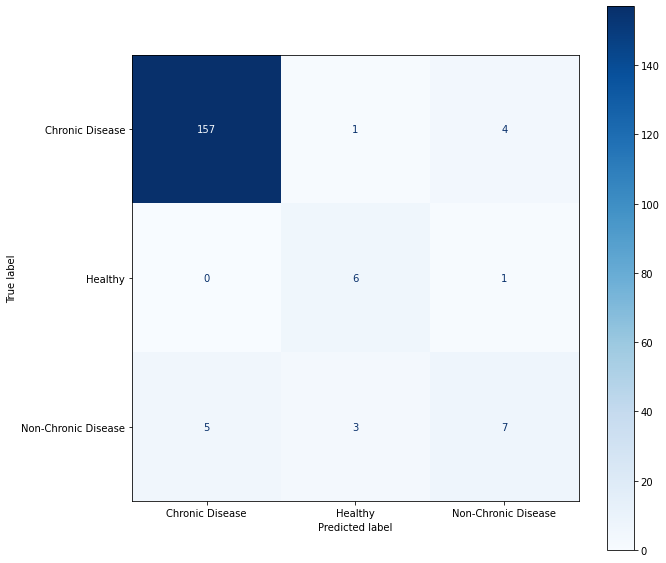

In [51]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

# Models: 1cycle policy

### ResNet-18

Better model found at epoch 0 with accuracy value: 0.06756756454706192.
Better model found at epoch 1 with accuracy value: 0.20270270109176636.
Better model found at epoch 2 with accuracy value: 0.4324324429035187.
Better model found at epoch 3 with accuracy value: 0.6013513803482056.
Better model found at epoch 4 with accuracy value: 0.6891891956329346.
Better model found at epoch 5 with accuracy value: 0.7162162065505981.
Better model found at epoch 6 with accuracy value: 0.7432432174682617.
Better model found at epoch 7 with accuracy value: 0.8040540814399719.
Better model found at epoch 8 with accuracy value: 0.8581081032752991.
Better model found at epoch 9 with accuracy value: 0.8986486196517944.
Better model found at epoch 11 with accuracy value: 0.9054054021835327.
Better model found at epoch 12 with accuracy value: 0.9256756901741028.
Better model found at epoch 13 with accuracy value: 0.9324324131011963.
Better model found at epoch 18 with accuracy value: 0.9459459185600281.


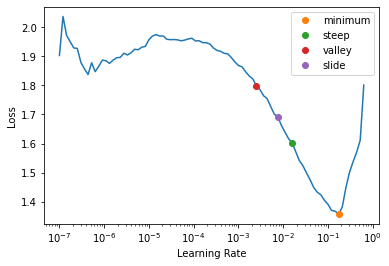

In [52]:
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

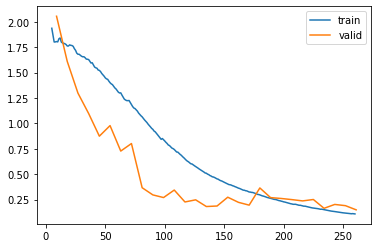

In [53]:
learn.recorder.plot_loss()

0.907608695652174 0.7284648697512669 0.5623328614126161 0.5557319223985892 0.9011978171039449 0.5790629875995729
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       162
           1       0.22      0.29      0.25         7
           2       0.55      0.40      0.46        15

    accuracy                           0.91       184
   macro avg       0.58      0.56      0.56       184
weighted avg       0.91      0.91      0.91       184



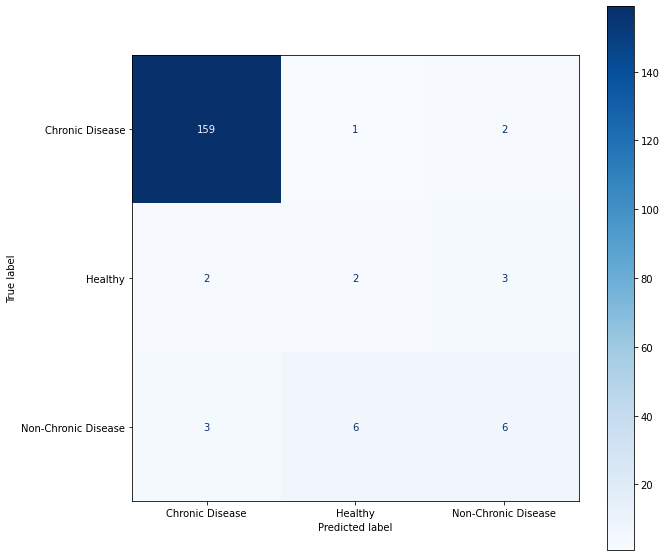

In [54]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-34

Better model found at epoch 0 with accuracy value: 0.09459459781646729.
Better model found at epoch 1 with accuracy value: 0.38513514399528503.
Better model found at epoch 2 with accuracy value: 0.5540540814399719.
Better model found at epoch 4 with accuracy value: 0.7027027010917664.
Better model found at epoch 6 with accuracy value: 0.7837837934494019.
Better model found at epoch 7 with accuracy value: 0.8175675868988037.
Better model found at epoch 8 with accuracy value: 0.8648648858070374.
Better model found at epoch 9 with accuracy value: 0.8918918967247009.
Better model found at epoch 11 with accuracy value: 0.9256756901741028.
Better model found at epoch 18 with accuracy value: 0.9391891956329346.
Better model found at epoch 22 with accuracy value: 0.9459459185600281.
Better model found at epoch 31 with accuracy value: 0.9527027010917664.
Better model found at epoch 37 with accuracy value: 0.9594594836235046.
No improvement since epoch 37: early stopping


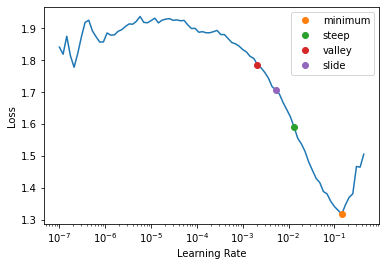

In [55]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

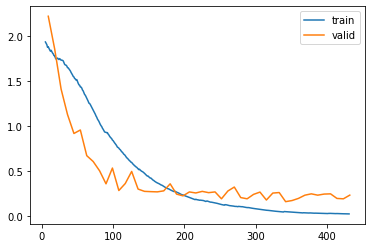

In [56]:
learn.recorder.plot_loss()

0.9130434782608695 0.8000456481189495 0.6667880406198163 0.6840094062316284 0.9160818900062706 0.6529899171408605
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       162
           1       0.43      0.43      0.43         7
           2       0.56      0.67      0.61        15

    accuracy                           0.91       184
   macro avg       0.65      0.68      0.67       184
weighted avg       0.92      0.91      0.92       184



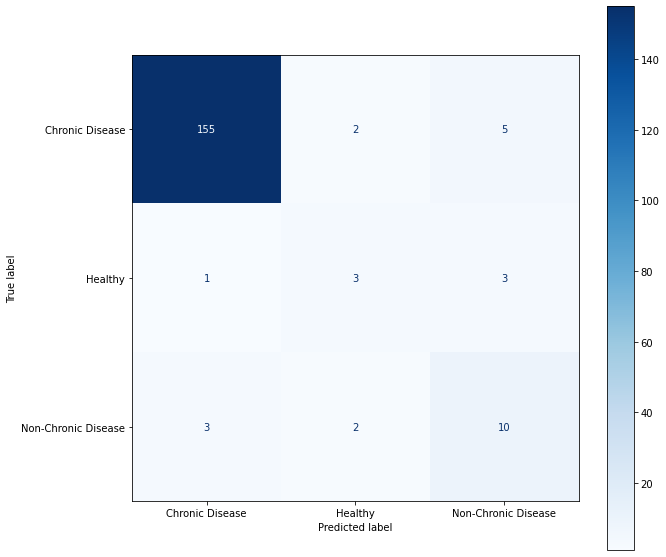

In [57]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-50

Better model found at epoch 0 with accuracy value: 0.4189189076423645.
Better model found at epoch 1 with accuracy value: 0.5675675868988037.
Better model found at epoch 4 with accuracy value: 0.662162184715271.
Better model found at epoch 5 with accuracy value: 0.6824324131011963.
Better model found at epoch 7 with accuracy value: 0.8040540814399719.
Better model found at epoch 9 with accuracy value: 0.8243243098258972.
Better model found at epoch 10 with accuracy value: 0.8648648858070374.
Better model found at epoch 11 with accuracy value: 0.8783783912658691.
Better model found at epoch 12 with accuracy value: 0.8986486196517944.
Better model found at epoch 14 with accuracy value: 0.9189189076423645.
Better model found at epoch 16 with accuracy value: 0.9391891956329346.
Better model found at epoch 19 with accuracy value: 0.9459459185600281.
Better model found at epoch 28 with accuracy value: 0.9527027010917664.
Better model found at epoch 29 with accuracy value: 0.9662162065505981.

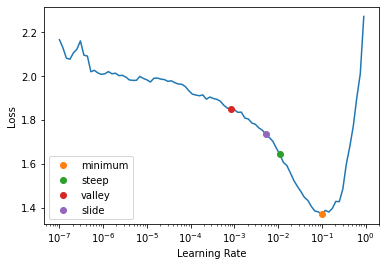

In [58]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

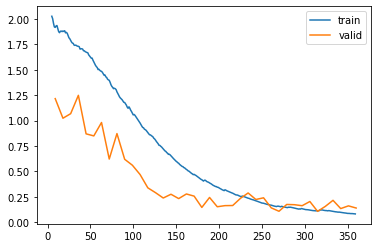

In [59]:
learn.recorder.plot_loss()

0.9402173913043478 0.8060580439835836 0.7298948416834595 0.6995296884185773 0.9125863995485899 0.7677376171352074
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       162
           1       0.67      0.57      0.62         7
           2       0.67      0.53      0.59        15

    accuracy                           0.94       184
   macro avg       0.77      0.70      0.73       184
weighted avg       0.93      0.94      0.94       184



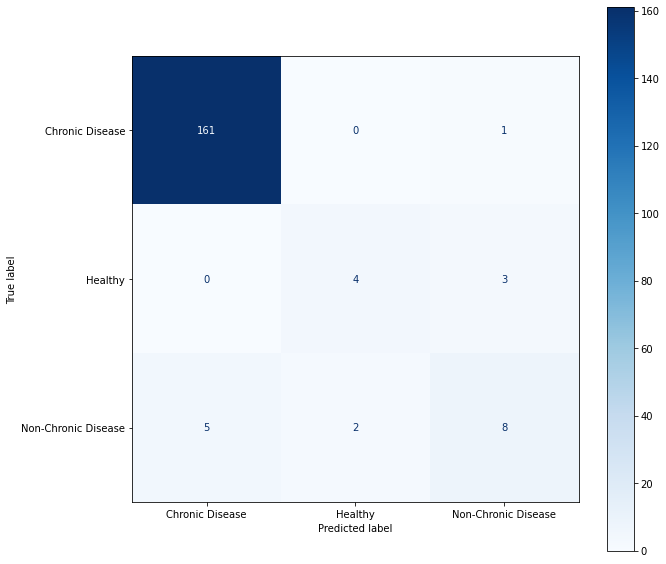

In [60]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-101

Better model found at epoch 0 with accuracy value: 0.09459459781646729.
Better model found at epoch 1 with accuracy value: 0.2432432472705841.
Better model found at epoch 2 with accuracy value: 0.4932432472705841.
Better model found at epoch 4 with accuracy value: 0.5608108043670654.
Better model found at epoch 5 with accuracy value: 0.7162162065505981.
Better model found at epoch 6 with accuracy value: 0.7432432174682617.
Better model found at epoch 7 with accuracy value: 0.7770270109176636.
Better model found at epoch 9 with accuracy value: 0.837837815284729.
Better model found at epoch 10 with accuracy value: 0.8783783912658691.
Better model found at epoch 11 with accuracy value: 0.9189189076423645.
Better model found at epoch 19 with accuracy value: 0.9324324131011963.
Better model found at epoch 23 with accuracy value: 0.9459459185600281.
No improvement since epoch 23: early stopping


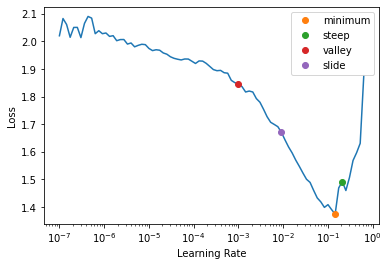

In [61]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

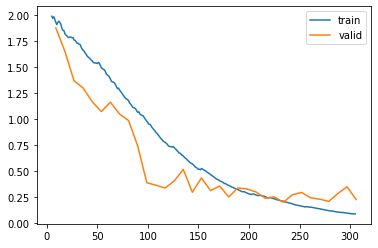

In [62]:
learn.recorder.plot_loss()

0.907608695652174 0.8546358189484367 0.6758580000222639 0.742445620223398 0.9668260176734753 0.6428571428571429
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       162
           1       0.43      0.43      0.43         7
           2       0.50      0.87      0.63        15

    accuracy                           0.91       184
   macro avg       0.64      0.74      0.68       184
weighted avg       0.94      0.91      0.92       184



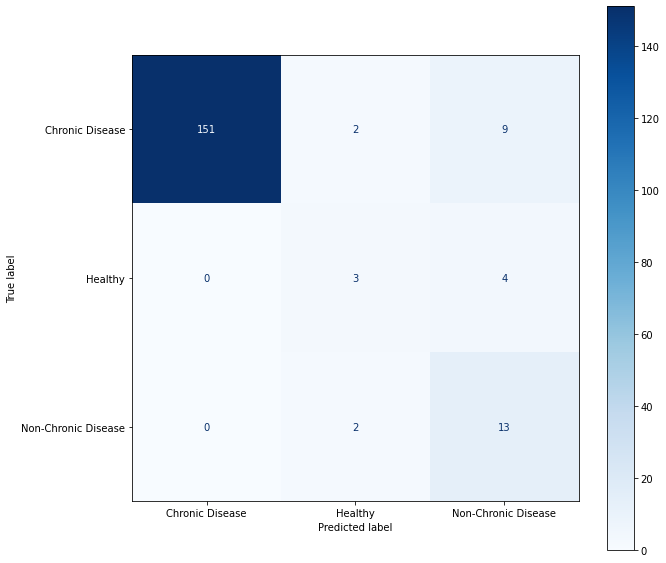

In [63]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg16_bn

Better model found at epoch 0 with accuracy value: 0.0878378376364708.
Better model found at epoch 1 with accuracy value: 0.12837837636470795.
Better model found at epoch 2 with accuracy value: 0.15540540218353271.
Better model found at epoch 3 with accuracy value: 0.3310810923576355.
Better model found at epoch 4 with accuracy value: 0.3445945978164673.
Better model found at epoch 5 with accuracy value: 0.4256756901741028.
Better model found at epoch 6 with accuracy value: 0.5202702879905701.
Better model found at epoch 7 with accuracy value: 0.5945945978164673.
Better model found at epoch 8 with accuracy value: 0.6486486196517944.
Better model found at epoch 9 with accuracy value: 0.7297297120094299.
Better model found at epoch 10 with accuracy value: 0.7770270109176636.
Better model found at epoch 11 with accuracy value: 0.7905405163764954.
Better model found at epoch 14 with accuracy value: 0.8445945978164673.
Better model found at epoch 15 with accuracy value: 0.8783783912658691.


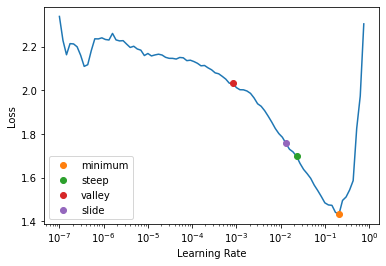

In [64]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

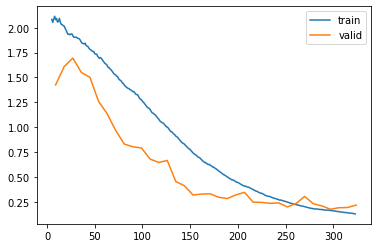

In [65]:
learn.recorder.plot_loss()

0.8804347826086957 0.7767388649251608 0.5954371299198885 0.6619635508524396 0.8915141789978817 0.5699703693334267
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       162
           1       0.36      0.71      0.48         7
           2       0.38      0.33      0.36        15

    accuracy                           0.88       184
   macro avg       0.57      0.66      0.60       184
weighted avg       0.90      0.88      0.89       184



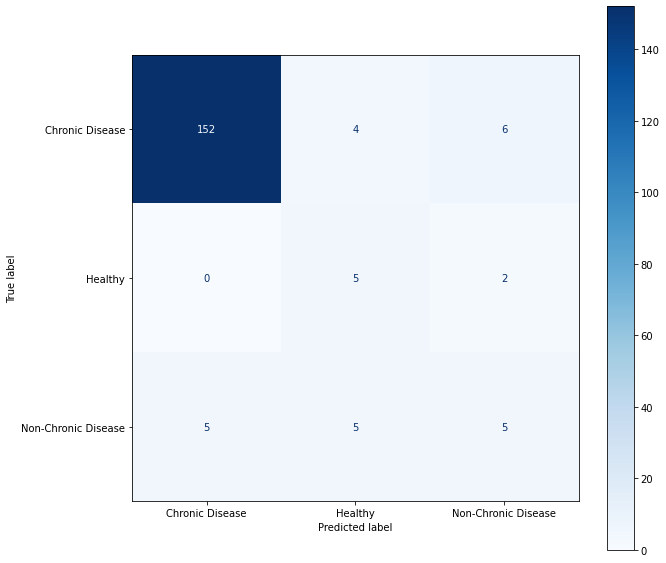

In [66]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg19_bn

Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 3 with accuracy value: 0.7837837934494019.
Better model found at epoch 4 with accuracy value: 0.7905405163764954.
Better model found at epoch 5 with accuracy value: 0.8175675868988037.
Better model found at epoch 6 with accuracy value: 0.837837815284729.
Better model found at epoch 7 with accuracy value: 0.8716216087341309.
Better model found at epoch 8 with accuracy value: 0.8986486196517944.
Better model found at epoch 10 with accuracy value: 0.9324324131011963.
No improvement since epoch 10: early stopping


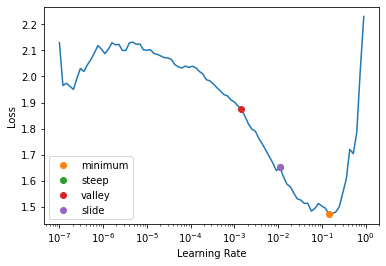

In [67]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

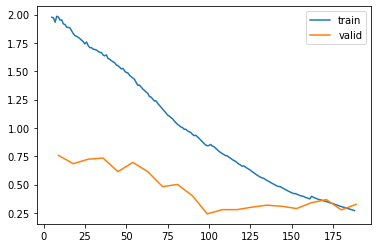

In [68]:
learn.recorder.plot_loss()

0.8804347826086957 0.696307490375287 0.47991917150795654 0.5148148148148147 0.8778001659357592 0.45711835334476847
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       162
           1       0.00      0.00      0.00         7
           2       0.41      0.60      0.49        15

    accuracy                           0.88       184
   macro avg       0.46      0.51      0.48       184
weighted avg       0.88      0.88      0.88       184



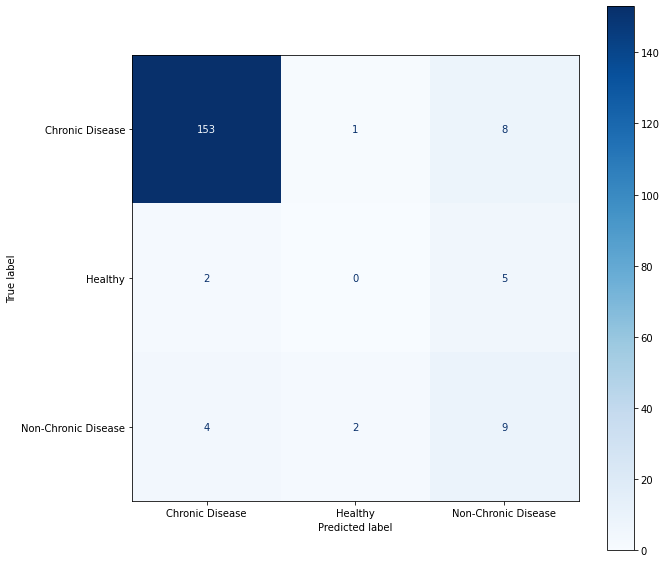

In [69]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### alexnet

Better model found at epoch 0 with accuracy value: 0.36486485600471497.
Better model found at epoch 1 with accuracy value: 0.5135135054588318.
Better model found at epoch 2 with accuracy value: 0.587837815284729.
Better model found at epoch 3 with accuracy value: 0.6554054021835327.
Better model found at epoch 4 with accuracy value: 0.7229729890823364.
Better model found at epoch 5 with accuracy value: 0.7702702879905701.
Better model found at epoch 6 with accuracy value: 0.8310810923576355.
Better model found at epoch 7 with accuracy value: 0.8513513803482056.
Better model found at epoch 8 with accuracy value: 0.8716216087341309.
Better model found at epoch 10 with accuracy value: 0.9054054021835327.
Better model found at epoch 20 with accuracy value: 0.912162184715271.
Better model found at epoch 22 with accuracy value: 0.9256756901741028.
No improvement since epoch 22: early stopping


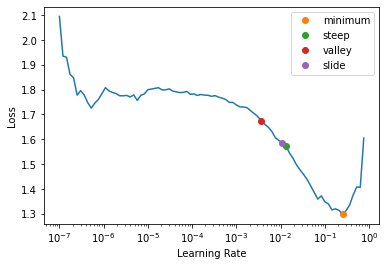

In [20]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

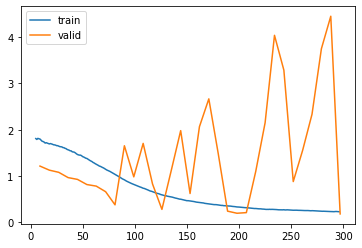

In [21]:
learn.recorder.plot_loss()

0.9184782608695652 0.7681470470982278 0.6991059226831585 0.6711346266901823 0.8651594675062731 0.7339357429718875
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       162
           1       0.67      0.57      0.62         7
           2       0.58      0.47      0.52        15

    accuracy                           0.92       184
   macro avg       0.73      0.67      0.70       184
weighted avg       0.91      0.92      0.91       184



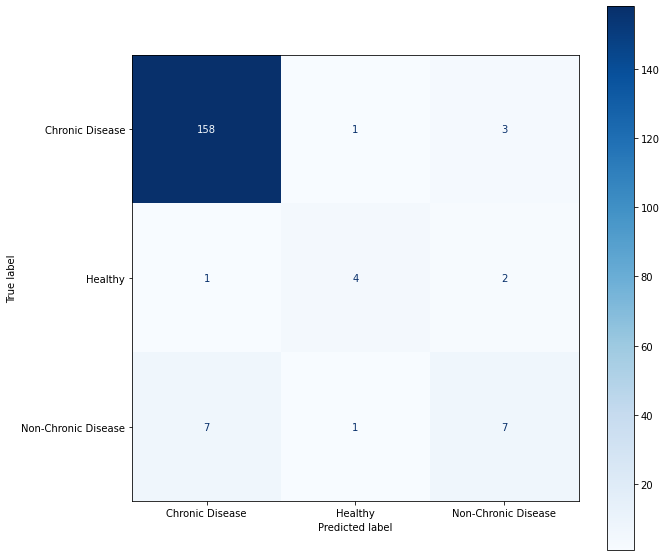

In [22]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### squeezenet1_0

Better model found at epoch 0 with accuracy value: 0.1756756752729416.
Better model found at epoch 1 with accuracy value: 0.3581081032752991.
Better model found at epoch 2 with accuracy value: 0.5067567825317383.
Better model found at epoch 3 with accuracy value: 0.6148648858070374.
Better model found at epoch 4 with accuracy value: 0.6824324131011963.
Better model found at epoch 5 with accuracy value: 0.7162162065505981.
Better model found at epoch 6 with accuracy value: 0.7297297120094299.
Better model found at epoch 7 with accuracy value: 0.8310810923576355.
Better model found at epoch 8 with accuracy value: 0.837837815284729.
Better model found at epoch 10 with accuracy value: 0.8851351141929626.
Better model found at epoch 13 with accuracy value: 0.9054054021835327.
Better model found at epoch 16 with accuracy value: 0.9256756901741028.
Better model found at epoch 22 with accuracy value: 0.9324324131011963.
Better model found at epoch 24 with accuracy value: 0.9459459185600281.
No

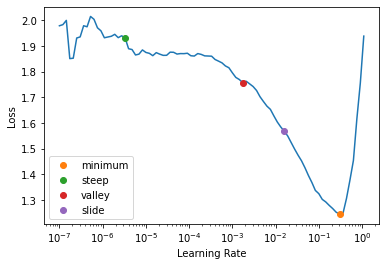

In [73]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

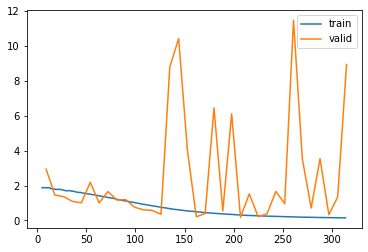

In [74]:
learn.recorder.plot_loss()

0.9184782608695652 0.8208233354039525 0.7219814241486068 0.7368606701940035 0.9047860006139015 0.7090924775707385
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       162
           1       0.62      0.71      0.67         7
           2       0.53      0.53      0.53        15

    accuracy                           0.92       184
   macro avg       0.71      0.74      0.72       184
weighted avg       0.92      0.92      0.92       184



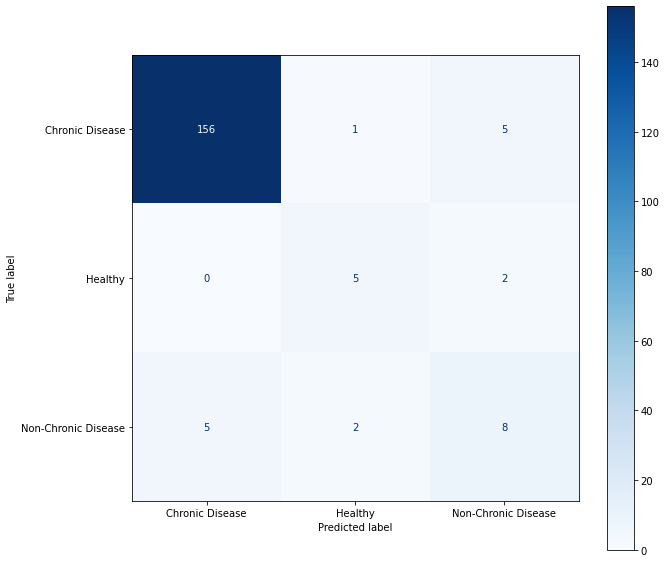

In [75]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### densenet121

Better model found at epoch 0 with accuracy value: 0.36486485600471497.
Better model found at epoch 1 with accuracy value: 0.46621620655059814.
Better model found at epoch 2 with accuracy value: 0.5810810923576355.
Better model found at epoch 3 with accuracy value: 0.6148648858070374.
Better model found at epoch 4 with accuracy value: 0.662162184715271.
Better model found at epoch 6 with accuracy value: 0.7229729890823364.
Better model found at epoch 7 with accuracy value: 0.7770270109176636.
Better model found at epoch 9 with accuracy value: 0.8445945978164673.
Better model found at epoch 10 with accuracy value: 0.9189189076423645.
Better model found at epoch 17 with accuracy value: 0.9324324131011963.
Better model found at epoch 24 with accuracy value: 0.9391891956329346.
No improvement since epoch 24: early stopping


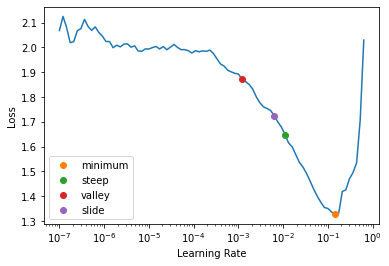

In [76]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

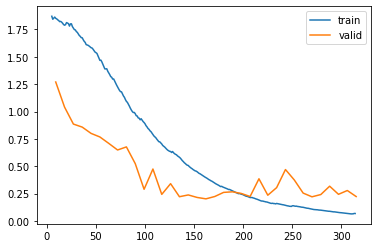

In [77]:
learn.recorder.plot_loss()

0.9239130434782609 0.7873146316504277 0.684317617866005 0.667960023515579 0.9066692397852764 0.7106083844580776
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       162
           1       0.60      0.43      0.50         7
           2       0.56      0.60      0.58        15

    accuracy                           0.92       184
   macro avg       0.71      0.67      0.68       184
weighted avg       0.92      0.92      0.92       184



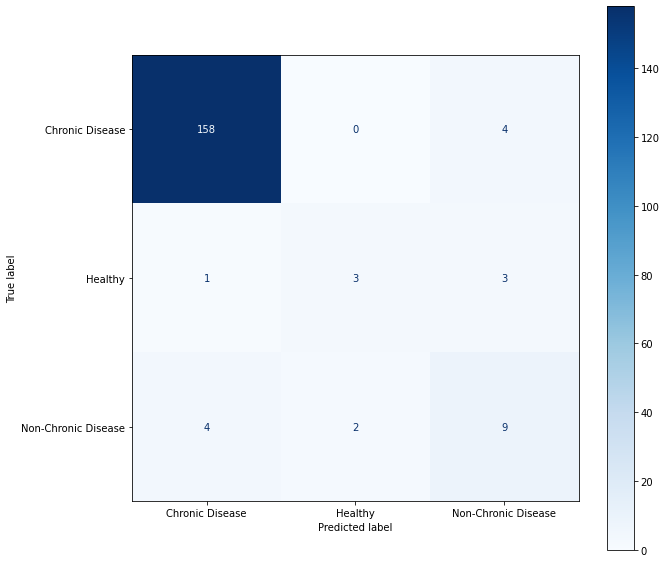

In [78]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### xresnet50

Better model found at epoch 0 with accuracy value: 0.22297297418117523.
Better model found at epoch 1 with accuracy value: 0.29054054617881775.
Better model found at epoch 2 with accuracy value: 0.5405405163764954.
Better model found at epoch 3 with accuracy value: 0.6689189076423645.
Better model found at epoch 4 with accuracy value: 0.7837837934494019.
Better model found at epoch 6 with accuracy value: 0.837837815284729.
Better model found at epoch 7 with accuracy value: 0.8513513803482056.
Better model found at epoch 8 with accuracy value: 0.8716216087341309.
Better model found at epoch 10 with accuracy value: 0.912162184715271.
Better model found at epoch 11 with accuracy value: 0.9324324131011963.
Better model found at epoch 13 with accuracy value: 0.9459459185600281.
No improvement since epoch 13: early stopping


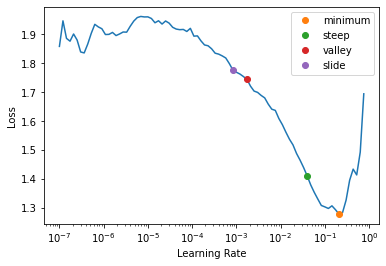

In [79]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

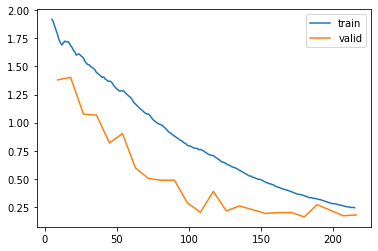

In [80]:
learn.recorder.plot_loss()

0.8967391304347826 0.8656179190294792 0.6907657098739901 0.7943562610229277 0.9368795770360308 0.6384711779448621
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       162
           1       0.43      0.86      0.57         7
           2       0.50      0.60      0.55        15

    accuracy                           0.90       184
   macro avg       0.64      0.79      0.69       184
weighted avg       0.93      0.90      0.91       184



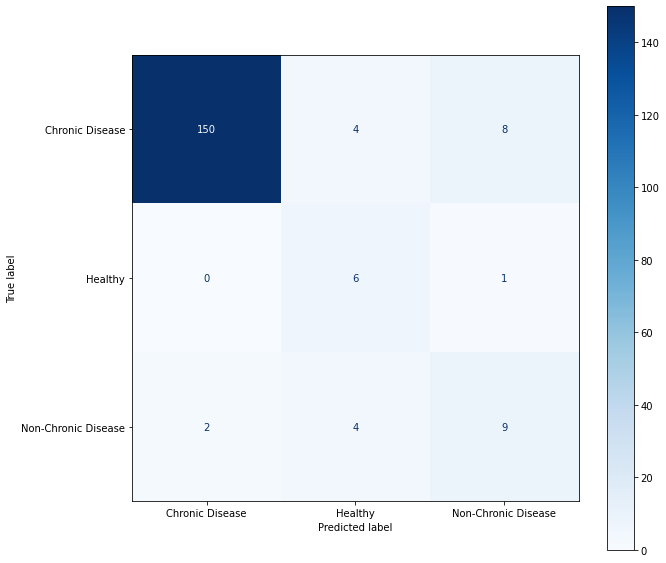

In [81]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()